Link to Dataset: https://www.kaggle.com/datasets/philosopher0808/real-vs-ai-generated-faces-dataset

Lie, Samuel Miracle Kristanto - 0706012210011
Nathan Darrell - 0706012210034

In [2]:
import tensorflow as tf

print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("\n\nNumber of GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

2.13.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18080258496042707459
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5724766208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1199170374992015555
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


Number of GPUs Available:  1


2025-06-07 12:00:52.762567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 5459 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5


## Read Dataset & Preprocessing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import warnings
warnings.filterwarnings('ignore')

In [4]:
import os

data_dir = "data_source"
print(os.listdir(data_dir))

['fake2', 'real3', 'real1', 'real4', 'fake3', 'fake1', 'fake4', 'real2']


In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling

# Directory of split folders
split_base = 'data_source'
image_size = (224, 224)
batch_size = 64

def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        label = 0 if folder.startswith('real') else 1  # real = 0, fake = 1
        for f in os.listdir(folder_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder_path, f))
                labels.append(label)

    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(split_base)

# Split manually into train/val
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=123, stratify=labels
)

def process_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32) / 255.0  # normalize
    return img, label

# Build train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build val dataset
validation_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
validation_ds = validation_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


2025-06-07 12:00:57.312538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5459 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5


In [6]:
print(f"Total images found: {len(image_paths)}")
print(f"Using {len(train_paths)} images for training.")
print(f"Using {len(val_paths)} images for validation.")

num_real = sum(1 for label in labels if label == 0)
num_fake = sum(1 for label in labels if label == 1)

print(f"Class distribution:")
print(f"Real images: {num_real}")
print(f"Fake images: {num_fake}")


Total images found: 80000
Using 64000 images for training.
Using 16000 images for validation.
Class distribution:
Real images: 40000
Fake images: 40000


## Model Building --> MobileNetV3 Large

In [7]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    RandomRotation(0.1),
    # RandomZoom(0.1),
    # RandomContrast(0.1),
    # layers.RandomBrightness(0.1),
])

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import Adam to set a lower learning rate
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC

def MobileNetV3_Large(input_shape=(224, 224, 3), num_classes=1):
    base_model = MobileNetV3Large(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = True

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True) 
    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu')(x) # Added a dense layer with ReLU activation
    x = Dropout(0.5)(x) # Increased dropout rate for the more complex head
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer,
        loss=BinaryCrossentropy(label_smoothing=0.05),
        metrics=[
            'accuracy',
            Precision(name="precision"),
            Recall(name="recall"),
            AUC(name="auc")
        ]
    )

    return model

In [9]:
model = MobileNetV3_Large()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257   

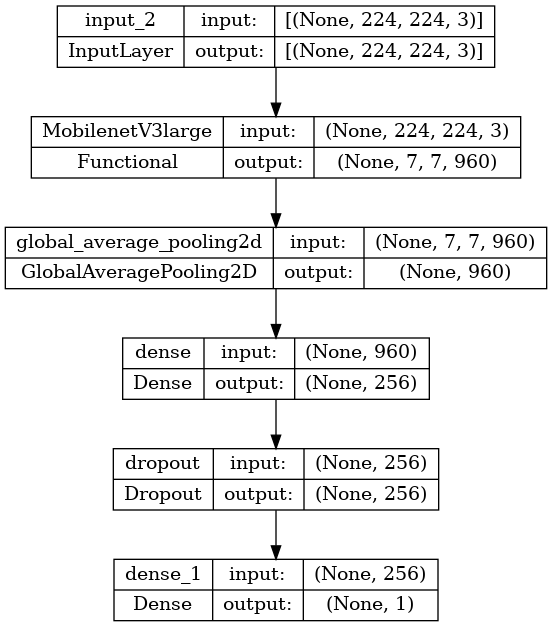

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

In [62]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(weights))
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_labels),
#     y=train_labels
# )
# class_weights_dict = dict(enumerate(class_weights))

In [63]:
from datetime import datetime

start_time = datetime.now()

history = model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = 50,
    validation_data = validation_ds,
    verbose = 1,
    # class_weight=class_weights,
    callbacks=[lr_callback, early_stop],
)

end_time = datetime.now()

model.save('reyalfakeh2.keras')

Epoch 1/50
1000/1000 [==============================] - 89s 81ms/step - loss: 0.5700 - accuracy: 0.7140 - precision: 0.7278 - recall: 0.6837 - auc: 0.7862 - val_loss: 0.5241 - val_accuracy: 0.7554 - val_precision: 0.7700 - val_recall: 0.7283 - val_auc: 0.8305 - lr: 1.0000e-04
Epoch 2/50
1000/1000 [==============================] - 92s 92ms/step - loss: 0.5243 - accuracy: 0.7539 - precision: 0.7787 - recall: 0.7094 - auc: 0.8308 - val_loss: 0.5120 - val_accuracy: 0.7624 - val_precision: 0.7630 - val_recall: 0.7613 - val_auc: 0.8468 - lr: 1.0000e-04
Epoch 3/50
1000/1000 [==============================] - 92s 92ms/step - loss: 0.5032 - accuracy: 0.7696 - precision: 0.7931 - recall: 0.7296 - auc: 0.8496 - val_loss: 0.4897 - val_accuracy: 0.7796 - val_precision: 0.8116 - val_recall: 0.7281 - val_auc: 0.8599 - lr: 1.0000e-04
Epoch 4/50
1000/1000 [==============================] - 89s 89ms/step - loss: 0.4882 - accuracy: 0.7803 - precision: 0.8022 - recall: 0.7441 - auc: 0.8618 - val_loss: 0.

## Model Evaluation & Testing

In [64]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, AUC

model = load_model(
    'reyalfakeh2.keras',
    custom_objects={
        'Precision': Precision,
        'Recall': Recall,
        'AUC': AUC
    }
)

In [65]:
import numpy as np

print("Training Duration: " + str(end_time - start_time))
print("Training")
print("Loss: {:.4f}".format(np.average(history.history['loss'])))
print("Accuracy: {:.4f}".format(np.average(history.history['accuracy'])))
print("Recall: {:.4f}".format(np.average(history.history['recall'])))
print("Precision: {:.4f}".format(np.average(history.history['precision'])))

print("Validation")
print("Loss: {:.4f}".format(np.average(history.history['val_loss'])))
print("Accuracy: {:.4f}".format(np.average(history.history['val_accuracy'])))
print("Recall: {:.4f}".format(np.average(history.history['val_recall'])))
print("Precision: {:.4f}".format(np.average(history.history['val_precision'])))

Training Duration: 0:20:54.578595
Training
Loss: 0.4571
Accuracy: 0.8016
Recall: 0.7735
Precision: 0.8191
Validation
Loss: 0.4783
Accuracy: 0.7907
Recall: 0.7636
Precision: 0.8080


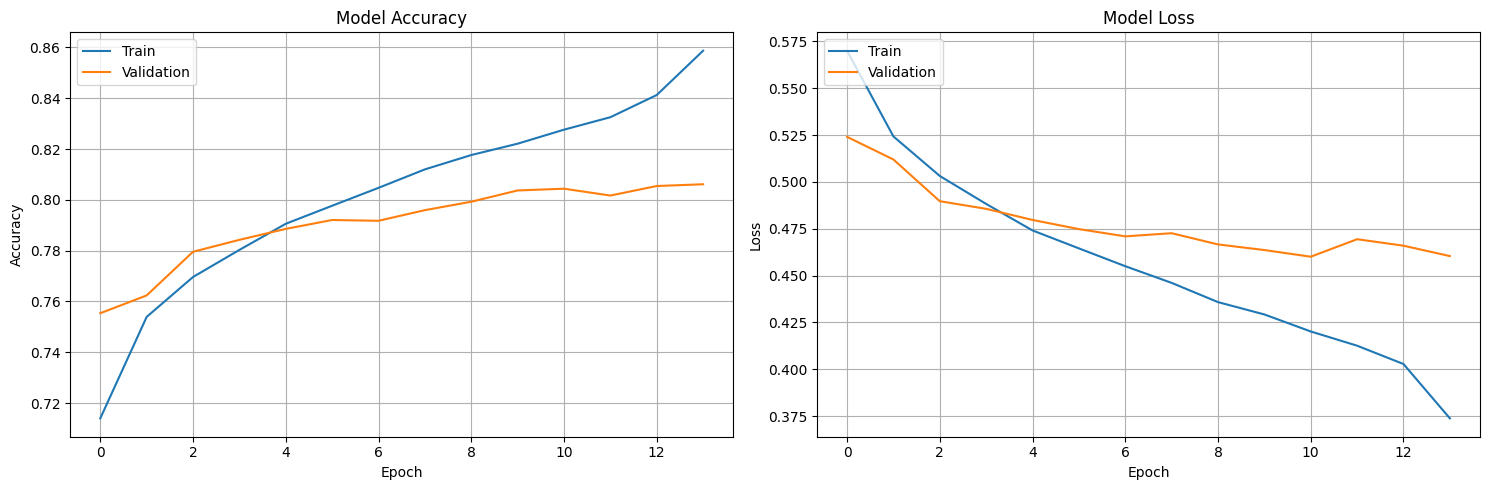

In [66]:
import matplotlib.pyplot as plt

def plot_training_history(hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(hist.history['accuracy'])
    ax1.plot(hist.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    ax2.plot(hist.history['loss'])
    ax2.plot(hist.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    
    plt.show()

plot_training_history(history)

/home/sift-pc/anaconda3/envs/tf-gpu/bin/python
              precision    recall  f1-score   support

        Real       0.80      0.82      0.81      8000
        Fake       0.81      0.79      0.80      8000

    accuracy                           0.80     16000
   macro avg       0.80      0.80      0.80     16000
weighted avg       0.80      0.80      0.80     16000



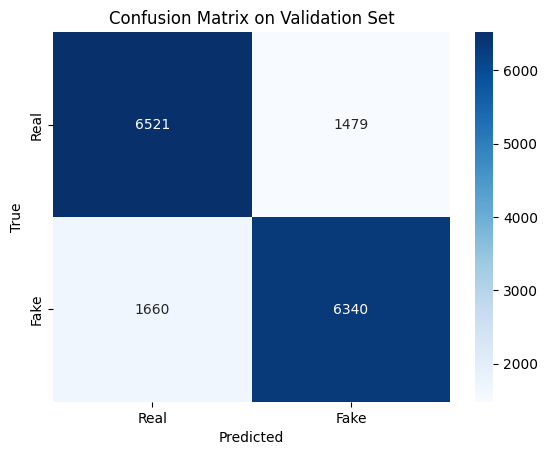

In [67]:
import sys
print(sys.executable)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []
y_prob = []

for images, labels in validation_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_prob.extend(preds.flatten())

# Classification report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Validation Set")
plt.show()

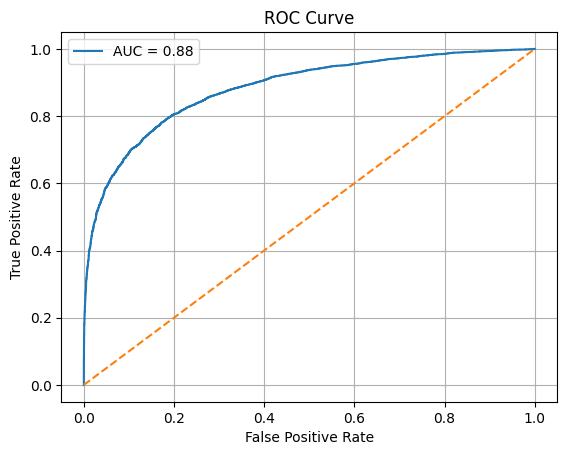

In [68]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

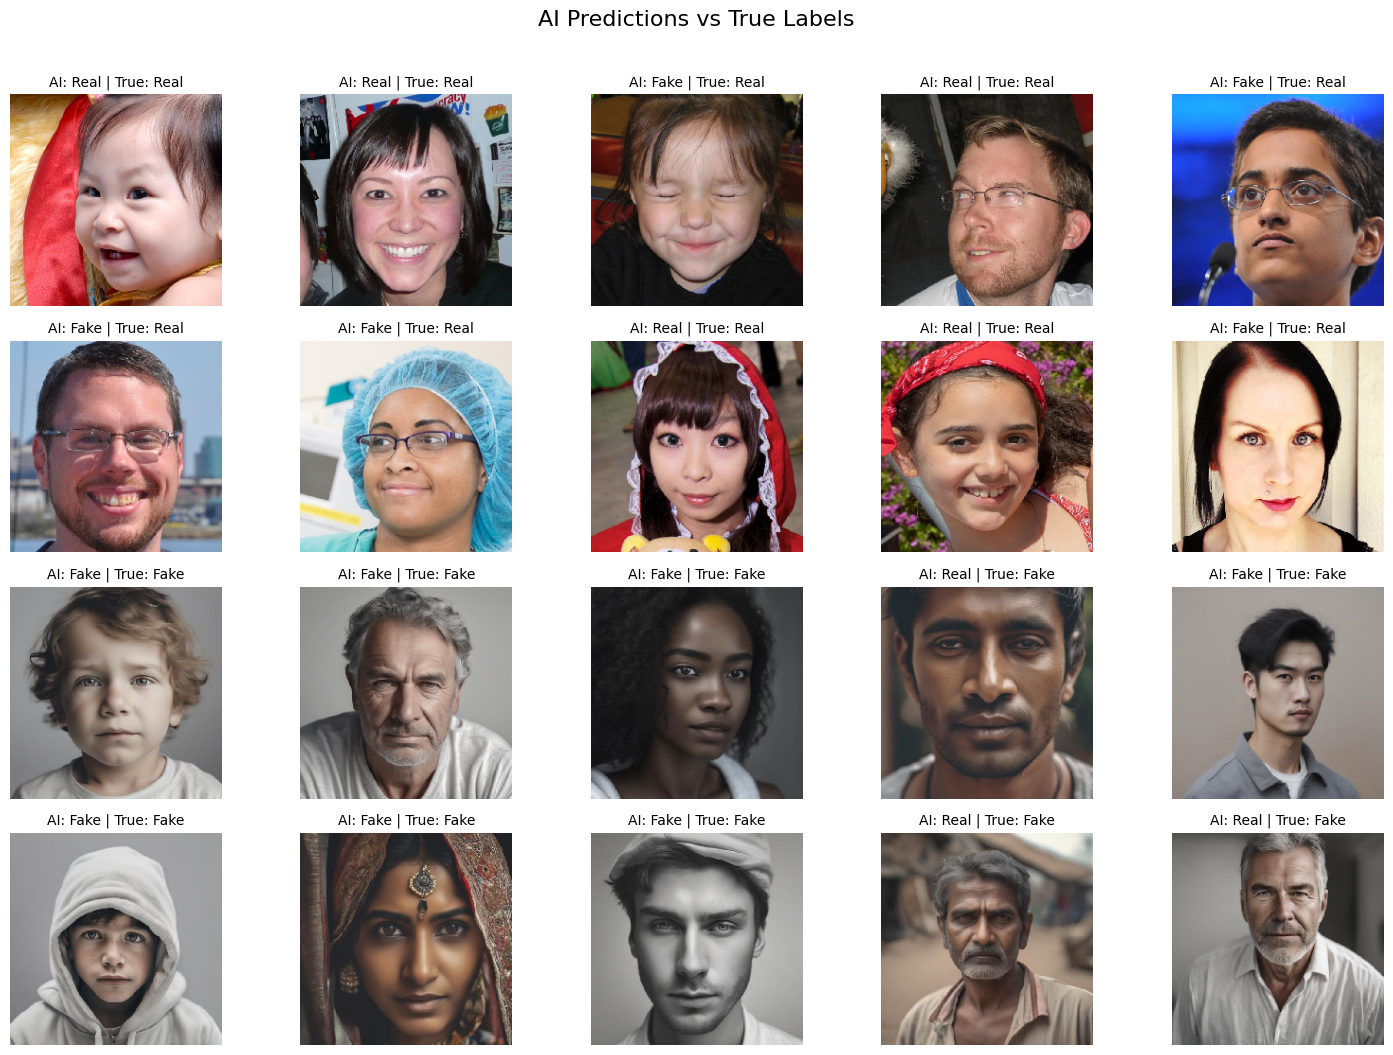

In [69]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

test_base = 'outside50k_data'
IMG_SIZE = (224, 224)

label_map = {
    'real8': 0,
    'fake6': 1
}

true_labels = []
predicted_labels = []

# Setup plot
plt.figure(figsize=(15, 10))
i = 1  # subplot index

for folder, label in label_map.items():
    folder_path = os.path.join(test_base, folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in image_files[:10]:  # limit per folder
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array_expanded = tf.expand_dims(img_array, 0) / 255.0

        prediction = model.predict(img_array_expanded, verbose=0)
        predicted = 1 if prediction[0][0] > 0.5 else 0

        true_labels.append(label)
        predicted_labels.append(predicted)

        # String labels
        pred_str = "Fake" if predicted == 1 else "Real"
        true_str = "Fake" if label == 1 else "Real"

        # Plotting
        plt.subplot(4, 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"AI: {pred_str} | True: {true_str}", fontsize=10)
        i += 1

        if i > 20:
            break
    if i > 20:
        break

plt.tight_layout()
plt.suptitle("AI Predictions vs True Labels", fontsize=16, y=1.05)
plt.show()
